In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from scipy.stats import t
import matplotlib.patches as patches
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
REGIONS   = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
FILEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/raw'
SAVEDIR   = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
LATRANGE  = (5.,25.)
LONRANGE  = (60.,90.)

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [4]:
data = open_dataset('IMERG_precipitation_flux.nc')

In [5]:
pr = data.pr.groupby('time.month').mean(dim='time')
jjprdiff = pr.sel(month=7)-pr.sel(month=6)
japrdiff = pr.sel(month=8)-pr.sel(month=7)

In [6]:
patchkwargs = dict(edgecolor='k',facecolor='none',linewidth=2)
prkwargs    = dict(cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=18,levels=15,extend='max')
maskkwargs  = dict(levels=[0.5,1],hatches=['//',None],colors='none')
diffkwargs  = dict(cmap='ColdHot_r',vmin=-9,vmax=9,levels=22,extend='both')
divkwargs   = dict(levels=[0],color='k',linewidth=0.5)

def make_patch(lonmin,lonmax,latmin,latmax,patchkwargs=patchkwargs):
    return patches.Rectangle((lonmin,latmin),lonmax-lonmin,latmax-latmin,**patchkwargs)

In [7]:
def t_test_significance(data,startmonth,endmonth,siglevel=0.05):
    # Get start and end arrays with dimensions (year, lat, lon)
    start = data.sel(time=data['time.month']==startmonth).groupby('time.year').mean(dim='time')
    end   = data.sel(time=data['time.month']==endmonth).groupby('time.year').mean(dim='time')
    diff  = end-start
    # Get monthly climatological means
    startmean = start.mean(dim='year')
    endmean   = end.mean(dim='year')
    meandiff  = endmean-startmean
    # Estimate critical value
    samplesize = len(end.year)
    degfreedom = samplesize-1 
    tcrit = t.ppf(1-siglevel/2,degfreedom)
    # Calculate t-statistic
    tstat = meandiff/(diff.std(dim='year',ddof=1)/np.sqrt(samplesize))
    # Boolean mask where statistically significant (absolute value of t-stat > tcrit)
    sigmask = (np.abs(tstat)>np.abs(tcrit))
    return sigmask

jjsig = t_test_significance(data.pr,startmonth=6,endmonth=7,siglevel=0.05)
jasig = t_test_significance(data.pr,startmonth=7,endmonth=8,siglevel=0.05)

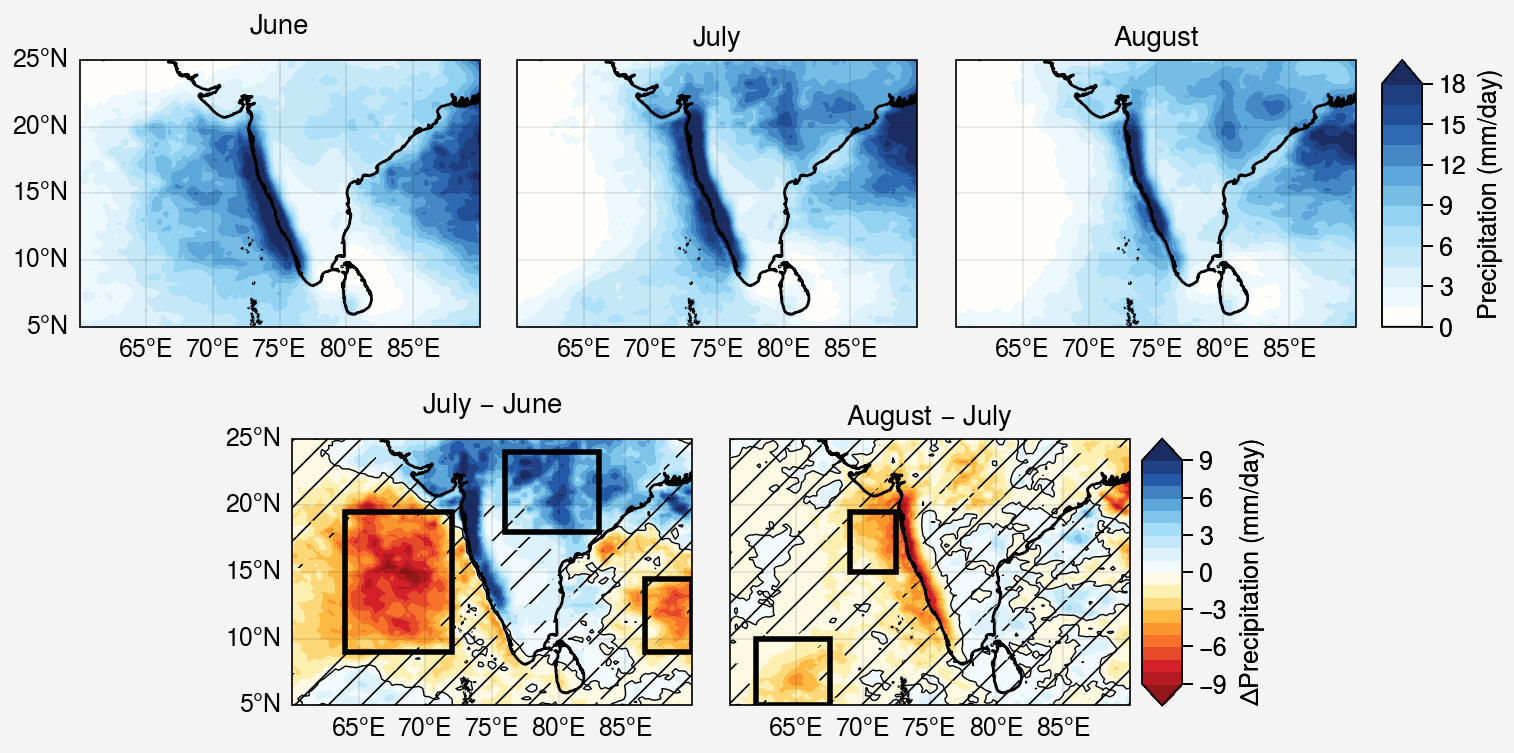

In [9]:
grid = [[1,1,2,2,3,3],
        [0,4,4,5,5,0]]

fig = pplt.figure(refwidth=2)
axs = fig.subplots(grid,proj='cyl')
axs.format(coast=True,coastlinewidth=1,latlim=LATRANGE,latlines=5,lonlim=LONRANGE,lonlines=5,lonlabels=True)
axs[0].format(title='June',latlabels=True)
axs[1].format(title='July')
axs[2].format(title='August')
axs[3].format(title='July $-$ June',latlabels=True)
axs[4].format(title='August $-$ July')

regionitems = list(REGIONS.items())
for region,coords in regionitems[:3]:
    axs[3].add_patch(make_patch(coords['lonmin'],coords['lonmax'],coords['latmin'],coords['latmax']))
for region,coords in regionitems[3:]:
    axs[4].add_patch(make_patch(coords['lonmin'],coords['lonmax'],coords['latmin'],coords['latmax']))
    
m = axs[0].contourf(pr.sel(month=6),**prkwargs)
axs[1].contourf(pr.sel(month=7),**prkwargs)
axs[2].contourf(pr.sel(month=8),**prkwargs)
axs[2].colorbar(m,loc='r',ticks=3,label='Precipitation (mm/day)')

m = axs[3].contourf(jjprdiff,**diffkwargs)
axs[3].contour(jjprdiff,**divkwargs)
axs[3].contourf(~jjsig,**maskkwargs)
axs[4].contourf(japrdiff,**diffkwargs)
axs[4].contour(japrdiff,**divkwargs)
axs[4].contourf(~jasig,**maskkwargs)
axs[4].colorbar(m,loc='r',ticks=3,label='$\Delta$Precipitation (mm/day)')

pplt.show()
fig.save(f'{SAVEDIR}/fig_1.png',dpi=600)